In [2]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

import pandas as pd

import numpy as np

In [3]:
data = pd.read_csv('cars.csv', sep=';')
data.drop(['Tiempo', 'EDAD_COCHE'],axis=1, inplace=True)
data.head()

,CODE,PRODUCTO,TIPO_CARROCERIA,COMBUSTIBLE,Potencia_,TRANS,FORMA_PAGO,ESTADO_CIVIL,GENERO,OcupaciOn,...,Campanna3,Zona _Renta,REV_Garantia,Averia_grave,QUEJA_CAC,COSTE_VENTA,km_anno,Mas_1_coche,Revisiones,Edad Cliente
0,CLI1,A,TIPO1,FUEL 1,Baja,M,Contado,CASADO,M,Empresa,...,NO,Medio-Bajo,NO DATA,Averia muy grave,SI,2892,0,0,2,18
1,CLI2,A,TIPO1,FUEL 1,Baja,M,Contado,CASADO,F,Empresa,...,NO,Medio-Bajo,SI,No,NO,1376,7187,0,2,53
2,CLI3,A,TIPO1,FUEL 1,Baja,M,Otros,CASADO,M,Empresa,...,NO,Medio,NO DATA,No,NO,1376,0,1,4,21
3,CLI4,A,TIPO1,FUEL 1,Baja,M,Financiera Marca,CASADO,F,Empresa,...,NO,Medio,SI,Averia muy grave,SI,2015,7256,1,4,48
4,CLI5,A,TIPO1,FUEL 1,Baja,M,Financiera Marca,CASADO,F,Funcionario,...,SI,Alto,NO DATA,No,NO,1818,0,1,3,21


## Columnas categóricas a columnas numéricas

In [4]:
# Identificar las columnas categóricas
categorical_columns = data.select_dtypes(include=['object']).columns

# Usar LabelEncoder para convertir las columnas categóricas en numéricas
label_encoders = {}
for column in categorical_columns:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column].astype(str))

In [5]:
# Identificar las columnas categóricas
categorical_columns = ['CODE', 'PRODUCTO', 'TIPO_CARROCERIA', 'COMBUSTIBLE', 'Potencia_', 'TRANS', 'FORMA_PAGO',
                       'ESTADO_CIVIL', 'GENERO', 'OcupaciOn', 'PROVINCIA', 'Campanna1', 'Campanna2', 'Campanna3',
                       'Zona _Renta', 'REV_Garantia', 'Averia_grave', 'QUEJA_CAC']

# Aplicar LabelEncoder a las columnas categóricas
label_encoders = {}
for column in categorical_columns:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column].astype(str))

# Asegúrate de que ahora todas las columnas sean numéricas
print(data.dtypes)

CODE               int32
PRODUCTO           int32
TIPO_CARROCERIA    int32
COMBUSTIBLE        int32
Potencia_          int32
TRANS              int32
FORMA_PAGO         int32
ESTADO_CIVIL       int32
GENERO             int32
OcupaciOn          int32
PROVINCIA          int32
Campanna1          int32
Campanna2          int32
Campanna3          int32
Zona _Renta        int32
REV_Garantia       int32
Averia_grave       int32
QUEJA_CAC          int32
COSTE_VENTA        int64
km_anno            int64
Mas_1_coche        int64
Revisiones         int64
Edad Cliente       int64
dtype: object


## Separando los datos en X e Y

In [6]:
# Separar las características (X) de la variable objetivo (y)
X = data.drop('Mas_1_coche', axis=1)
y = data['Mas_1_coche']

Dividimos los datos en entrenamiento y prueba

In [7]:
# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Creamos el modelo XGBoost

In [8]:
# Crear el modelo XGBoost
model_xgb = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    use_label_encoder=False
)

# Entrenar el modelo
model_xgb.fit(X_train, y_train)
train_score = model_xgb.score(X_train, y_train)

c:\Users\mglez\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:19:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


## Realizamos predicciones y evaluamos el modelo

In [9]:
# Realizar predicciones y evaluar el rendimiento
y_pred_xgb = model_xgb.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
report_xgb = classification_report(y_test, y_pred_xgb)

print(f"Accuracy: {accuracy_xgb}")
print("Classification Report:\n", report_xgb)

Accuracy: 0.8709732988802756
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.93      0.91      8338
           1       0.80      0.73      0.76      3272

    accuracy                           0.87     11610
   macro avg       0.85      0.83      0.84     11610
weighted avg       0.87      0.87      0.87     11610



## Procesamos el nuevo conjunto de datos y miramos las predicciones

In [10]:
ndf = pd.read_csv('cars_input.csv', delimiter=';')

In [11]:
# Preprocesar el nuevo conjunto de datos
for column in categorical_columns:
    if column in ndf.columns:
        # Detectar nuevas categorías
        categorias_vistas = set(label_encoders[column].classes_)
        categorias_nuevas = set(ndf[column].astype(str).unique()) - categorias_vistas
        
        if categorias_nuevas:
            print(f"Column '{column}' contains new categories: {categorias_nuevas}")

            # Asignar una categoría especial "Desconocido" para las nuevas categorías
            ndf[column] = ndf[column].apply(lambda x: x if x in categorias_vistas else 'Desconocido')
            
            # Añadir la categoría "Desconocido" a las clases del LabelEncoder
            label_encoders[column].classes_ = np.append(label_encoders[column].classes_, 'Desconocido')

        # Transformar la columna categórica usando el LabelEncoder entrenado
        ndf[column] = label_encoders[column].transform(ndf[column].astype(str))

Column 'CODE' contains new categories: {'CLIN15996', 'CLIN22008', 'CLIN19715', 'CLIN8890', 'CLIN23181', 'CLIN11073', 'CLIN20936', 'CLIN16309', 'CLIN2668', 'CLIN7902', 'CLIN3199', 'CLIN7990', 'CLIN12041', 'CLIN2746', 'CLIN838', 'CLIN10450', 'CLIN6388', 'CLIN5595', 'CLIN11224', 'CLIN12877', 'CLIN12675', 'CLIN1159', 'CLIN20129', 'CLIN20997', 'CLIN22404', 'CLIN15366', 'CLIN909', 'CLIN7182', 'CLIN10452', 'CLIN20371', 'CLIN5877', 'CLIN13318', 'CLIN23085', 'CLIN6825', 'CLIN1850', 'CLIN8553', 'CLIN17864', 'CLIN19408', 'CLIN316', 'CLIN19035', 'CLIN4025', 'CLIN19323', 'CLIN1635', 'CLIN5055', 'CLIN5969', 'CLIN7170', 'CLIN16828', 'CLIN20341', 'CLIN20164', 'CLIN14354', 'CLIN607', 'CLIN291', 'CLIN16604', 'CLIN7747', 'CLIN160', 'CLIN13157', 'CLIN4175', 'CLIN20310', 'CLIN2934', 'CLIN3800', 'CLIN17749', 'CLIN214', 'CLIN2647', 'CLIN4540', 'CLIN21535', 'CLIN21263', 'CLIN12571', 'CLIN18109', 'CLIN9825', 'CLIN14450', 'CLIN12390', 'CLIN10132', 'CLIN12843', 'CLIN14508', 'CLIN8235', 'CLIN17784', 'CLIN5248', '

In [12]:
# Encontrar las columnas faltantes en el nuevo conjunto de datos
columnas_faltantes = set(X_train.columns) - set(ndf.columns)
print(f"Columnas faltantes en el nuevo conjunto de datos: {columnas_faltantes}")

Columnas faltantes en el nuevo conjunto de datos: set()


In [13]:
# Asegúrate de que el nuevo conjunto de datos tenga las mismas columnas que X_train
X_nuevo = ndf[X_train.columns]  # Utiliza las mismas características que en el entrenamiento
X_train.columns

Index(['CODE', 'PRODUCTO', 'TIPO_CARROCERIA', 'COMBUSTIBLE', 'Potencia_',
       'TRANS', 'FORMA_PAGO', 'ESTADO_CIVIL', 'GENERO', 'OcupaciOn',
       'PROVINCIA', 'Campanna1', 'Campanna2', 'Campanna3', 'Zona _Renta',
       'REV_Garantia', 'Averia_grave', 'QUEJA_CAC', 'COSTE_VENTA', 'km_anno',
       'Revisiones', 'Edad Cliente'],
      dtype='object')

In [14]:
# Realizar predicciones con el modelo entrenado
y_nuevo_pred = model_xgb.predict(X_nuevo)

In [15]:
# Realizar predicciones con el modelo entrenado
y_nuevo_pred = model_xgb.predict(X_nuevo)

# Mostrar las primeras predicciones
print("Predicciones en el nuevo conjunto de datos:", y_nuevo_pred[:10])

Predicciones en el nuevo conjunto de datos: [1 0 0 0 0 0 0 0 0 0]


## Verificar que el modelo no está sobreajustado

Como no tenemos datos para comparar las predicciones, vemos qué nos ha predicho el propio modelo

In [16]:
# Realizar validación cruzada en el conjunto de datos original
cv_scores = cross_val_score(model_xgb, X, y, cv=5)  # cv=5 para 5-fold cross-validation
cv_scores_mean = cv_scores.mean()

print(f"Validation accuracy scores: {cv_scores}")
print(f"Mean cross-validation accuracy: {cv_scores_mean}")

c:\Users\mglez\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:19:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\mglez\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:19:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\mglez\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:19:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Validation accuracy scores: [0.85572782 0.86778639 0.86752799 0.86546081 0.86846412]
Mean cross-validation accuracy: 0.8649934274611999


Ahora, una vez vista la precisión del modelo, verificamos que no esté sobreajustado

In [17]:
# Comprobación el puntaje del entrenamiento
print(f"Puntaje de Entrenamiento: {train_score}")
print(f"Puntaje de validación cruzada: {cv_scores_mean}")

Puntaje de Entrenamiento: 0.8883050883955296
Puntaje de validación cruzada: 0.8649934274611999


In [18]:
# Interpretación de los puntajes
if train_score > cv_scores_mean*1.2:
    print("El modelo está sobreajustado.")
else:
    print("El modelo parece estar bien generalizado.")

El modelo parece estar bien generalizado.


## Curva ROC

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [20]:
# Obtener las probabilidades predichas para la clase positiva (Mas_1_coche == 1)
y_pred_prob = model_xgb.predict_proba(X_test)[:, 1]  # Probabilidad de la clase positiva


In [21]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

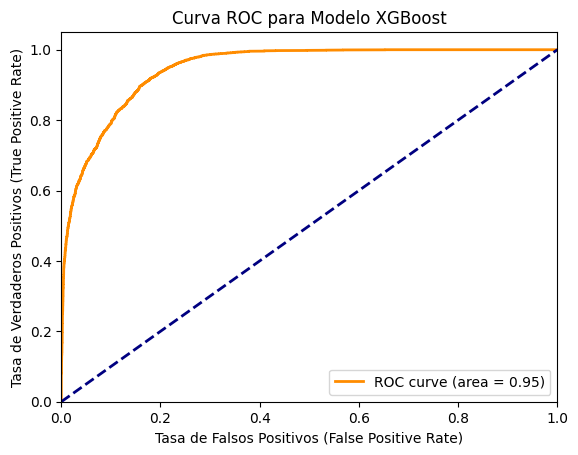

In [22]:
# Trazar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Línea diagonal (clasificación aleatoria)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (False Positive Rate)')
plt.ylabel('Tasa de Verdaderos Positivos (True Positive Rate)')
plt.title('Curva ROC para Modelo XGBoost')
plt.legend(loc="lower right")
plt.show()

In [23]:
import joblib

In [24]:
ruta_modelo = 'modelo_xGBoost.joblib'
joblib.dump(model_xgb, ruta_modelo)

['modelo_xGBoost.joblib']